In [2]:
# cross_subject_train.py
import numpy as np
import os
from utilities import *
import h5py
from scipy.stats import zscore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Use the same label mapping and model architecture as main.py
LABEL_MAP = {
    'rest': 0,
    'task_motor': 1, 
    'task_story': 2,
    'task_working': 3
}

class MEGDataset(Dataset):
    """Custom Dataset for MEG data - same as main.py"""
    def __init__(self, data_list, labels):
        self.data_list = data_list
        self.labels = labels
        
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        data = self.data_list[idx]
        data = torch.FloatTensor(data).unsqueeze(0)
        label = LABEL_MAP[self.labels[idx]]
        label = torch.LongTensor([label]).squeeze()
        return data, label

class TinyMEGNet(nn.Module):
    """Same model architecture as main.py"""
    def __init__(self, num_classes=4, input_channels=248, input_time_steps=2227):
        super(TinyMEGNet, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 4, kernel_size=(32, 64), stride=(8, 16))
        self.conv2 = nn.Conv2d(4, 8, kernel_size=(4, 8), stride=(2, 4))
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(8, num_classes)
        self.dropout = nn.Dropout(0.5)
        
        print(f"TinyMEGNet created with {sum(p.numel() for p in self.parameters()):,} parameters")
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout(x)
        x = F.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class CNNLSTMNet(nn.Module):
    """
    Hybrid CNN+LSTM model for MEG classification
    
    Architecture:
    1. CNN layers extract spatial features from MEG channels
    2. Reshape CNN output into temporal sequences 
    3. LSTM processes temporal dependencies
    4. Final classification layer
    """
    def __init__(self, num_classes=4, input_channels=248, input_time_steps=2227, 
                 lstm_hidden_size=64, num_lstm_layers=2, dropout=0.3):
        super(CNNLSTMNet, self).__init__()
        
        self.input_channels = input_channels
        self.input_time_steps = input_time_steps
        
        # Step 1: CNN for spatial feature extraction
        # Use 1D convolutions along the channel dimension to extract spatial patterns
        self.spatial_conv = nn.Sequential(
            # First conv: reduce channel dimension while preserving time
            nn.Conv2d(1, 16, kernel_size=(16, 1), stride=(4, 1), padding=(6, 0)),  # Channels: 248->~62
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            
            # Second conv: further spatial reduction
            nn.Conv2d(16, 32, kernel_size=(8, 1), stride=(2, 1), padding=(3, 0)),  # Channels: ~62->~31
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            
            # Third conv: final spatial features
            nn.Conv2d(32, 64, kernel_size=(4, 1), stride=(2, 1), padding=(1, 0)),  # Channels: ~31->~16
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        
        # Calculate the spatial output size after convolutions
        self._calculate_conv_output_size()
        
        # Step 2: Temporal convolution to create meaningful time segments
        # Use 1D conv along time dimension to downsample and create feature sequences
        self.temporal_conv = nn.Sequential(
            nn.Conv1d(self.spatial_features, 128, kernel_size=16, stride=8, padding=4),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            
            nn.Conv1d(128, 64, kernel_size=8, stride=4, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        
        # Calculate temporal output size
        self._calculate_temporal_output_size()
        
        # Step 3: LSTM for temporal sequence modeling
        self.lstm = nn.LSTM(
            input_size=64,  # Features from temporal conv
            hidden_size=lstm_hidden_size,
            num_layers=num_lstm_layers,
            batch_first=True,
            dropout=dropout if num_lstm_layers > 1 else 0,
            bidirectional=True  # Use bidirectional LSTM for better context
        )
        
        # Step 4: Classification head
        # Bidirectional LSTM doubles the hidden size
        lstm_output_size = lstm_hidden_size * 2
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(lstm_output_size, lstm_hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(lstm_hidden_size, num_classes)
        )
        
        print(f"CNNLSTMNet created with {sum(p.numel() for p in self.parameters()):,} parameters")
        print(f"  - Spatial features after CNN: {self.spatial_features}")
        print(f"  - Temporal sequence length: {self.temporal_length}")
        print(f"  - LSTM hidden size: {lstm_hidden_size} (bidirectional: {lstm_hidden_size*2})")
    
    def _calculate_conv_output_size(self):
        """Calculate spatial dimensions after CNN layers"""
        # Simulate forward pass to get output size
        with torch.no_grad():
            x = torch.zeros(1, 1, self.input_channels, self.input_time_steps)
            x = self.spatial_conv(x)
            self.spatial_channels_out = x.shape[2]
            self.spatial_features = x.shape[1] * x.shape[2]  # channels * height
    
    def _calculate_temporal_output_size(self):
        """Calculate temporal sequence length after temporal conv"""
        # Simulate the temporal convolution
        temp_length = self.input_time_steps
        # First temporal conv: kernel=16, stride=8, padding=4
        temp_length = (temp_length + 2*4 - 16) // 8 + 1
        # Second temporal conv: kernel=8, stride=4, padding=2  
        temp_length = (temp_length + 2*2 - 8) // 4 + 1
        self.temporal_length = temp_length
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # Step 1: Spatial feature extraction with CNN
        # Input: (batch, 1, 248, time_steps)
        spatial_features = self.spatial_conv(x)
        # Output: (batch, 64, reduced_channels, time_steps)
        
        # Step 2: Reshape for temporal processing
        # Combine channel and spatial dimensions into features
        # Then swap to (batch, time, features) for temporal conv
        spatial_features = spatial_features.view(batch_size, self.spatial_features, -1)
        # Now: (batch, spatial_features, time_steps)
        
        # Step 3: Temporal convolution to create sequence
        temporal_features = self.temporal_conv(spatial_features)
        # Output: (batch, 64, temporal_length)
        
        # Step 4: Prepare for LSTM (batch, seq_len, features)
        temporal_features = temporal_features.transpose(1, 2)
        # Now: (batch, temporal_length, 64)
        
        # Step 5: LSTM processing
        lstm_out, (hidden, cell) = self.lstm(temporal_features)
        # lstm_out: (batch, temporal_length, hidden_size*2) due to bidirectional
        
        # Step 6: Use the last output for classification
        # Take the last time step output
        final_output = lstm_out[:, -1, :]  # (batch, hidden_size*2)
        
        # Step 7: Classification
        logits = self.classifier(final_output)
        
        return logits

def load_and_normalize_files_batch(directory_path, batch_size=8, downsample_factor=None, verbose=False):
    """
    Load and normalize h5 files in batches to manage memory for Cross dataset
    
    Parameters:
    directory_path (str): Path to directory containing h5 files
    batch_size (int): Number of files to load per batch
    downsample_factor (int, optional): Factor by which to downsample the data
    verbose (bool): Whether to print batch loading progress
    
    Yields:
    tuple: (batch_data, batch_labels) for each batch
    """
    h5_files = [f for f in os.listdir(directory_path) if f.endswith('.h5')]
    if verbose:
        print(f"Found {len(h5_files)} files in {directory_path}")
    
    # Process files in batches
    for i in range(0, len(h5_files), batch_size):
        batch_files = h5_files[i:i + batch_size]
        batch_data = []
        batch_labels = []
        
        if verbose:
            print(f"Loading batch {i//batch_size + 1}/{(len(h5_files) + batch_size - 1)//batch_size} "
                  f"(files {i+1}-{min(i+batch_size, len(h5_files))})")
        
        for file in batch_files:
            # Extract task type from filename
            if file.startswith("task_"):
                parts = file.split('_')
                task_type = '_'.join(parts[:2])
            else:
                task_type = file.split('_')[0]
            
            # Load and process the data
            file_path = os.path.join(directory_path, file)
            matrix = read_h5py_file(file_path)
            
            # Downsample if specified
            if downsample_factor is not None:
                matrix = matrix[:, ::downsample_factor]
            
            # Normalize using Z-score
            normalized_matrix = zscore(matrix, axis=1, nan_policy='propagate')
            normalized_matrix = np.nan_to_num(normalized_matrix, nan=0.0)
            
            batch_data.append(normalized_matrix)
            batch_labels.append(task_type)
        
        yield batch_data, batch_labels

def train_one_epoch_batched(model, train_path, criterion, optimizer, batch_size=8, 
                           downsample_factor=16, dataloader_batch_size=4, device='cpu', verbose=False):
    """
    Train for one epoch using batched file loading
    """
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0
    batch_count = 0
    
    # Load and train on batches of files
    for batch_data, batch_labels in load_and_normalize_files_batch(
        train_path, batch_size=batch_size, downsample_factor=downsample_factor, verbose=verbose):
        
        # Create temporary dataset and dataloader for this batch
        temp_dataset = MEGDataset(batch_data, batch_labels)
        temp_dataloader = DataLoader(temp_dataset, batch_size=dataloader_batch_size, 
                                   shuffle=True, num_workers=0)
        
        # Train on this batch of files
        for inputs, labels in temp_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()
        
        batch_count += 1
        
        # Clear memory
        del temp_dataset, temp_dataloader, batch_data, batch_labels
    
    avg_loss = total_loss / (batch_count * dataloader_batch_size) if batch_count > 0 else 0
    accuracy = total_correct / total_samples if total_samples > 0 else 0
    
    return avg_loss, accuracy

def evaluate_model_batched(model, test_path, criterion, batch_size=8, 
                          downsample_factor=16, dataloader_batch_size=4, device='cpu', verbose=False):
    """
    Evaluate model using batched loading
    """
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_labels = []
    batch_count = 0
    
    with torch.no_grad():
        for batch_data, batch_labels in load_and_normalize_files_batch(
            test_path, batch_size=batch_size, downsample_factor=downsample_factor, verbose=verbose):
            
            temp_dataset = MEGDataset(batch_data, batch_labels)
            temp_dataloader = DataLoader(temp_dataset, batch_size=dataloader_batch_size, 
                                       shuffle=False, num_workers=0)
            
            for inputs, labels in temp_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                total_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
            
            batch_count += 1
            del temp_dataset, temp_dataloader, batch_data, batch_labels
    
    avg_loss = total_loss / (batch_count * dataloader_batch_size) if batch_count > 0 else 0
    accuracy = len([1 for i, j in zip(all_predictions, all_labels) if i == j]) / len(all_labels)
    
    return avg_loss, accuracy, all_predictions, all_labels

def train_cross_subject_model(filepath, use_cnn_lstm=False, epochs=100, file_batch_size=8, dataloader_batch_size=4, 
                             downsample_factor=16, lr=0.001, weight_decay=1e-4):
    """
    Train cross-subject model using the Cross dataset
    """
    # Setup paths
    cross_train_path = os.path.join(filepath, "Cross", "train")
    
    print(f"\n{'='*60}")
    print(f"  CROSS-SUBJECT TRAINING")
    print(f"{'='*60}")
    print(f"Training data path: {cross_train_path}")
    print(f"File batch size: {file_batch_size}")
    print(f"DataLoader batch size: {dataloader_batch_size}")
    print(f"Downsample factor: {downsample_factor}")
    print(f"Learning rate: {lr}")
    print(f"Weight decay: {weight_decay}")
    print(f"Model type: {'CNN+LSTM' if use_cnn_lstm else 'CNN-only'}")
    
    # Get sample data to determine input dimensions
    sample_batch_data, sample_batch_labels = next(load_and_normalize_files_batch(
        cross_train_path, batch_size=1, downsample_factor=downsample_factor, verbose=False))
    
    input_time_steps = sample_batch_data[0].shape[1]
    print(f"Input shape: (248, {input_time_steps})")
    
    # Initialize model based on use_cnn_lstm flag
    if use_cnn_lstm:
        model = CNNLSTMNet(num_classes=len(LABEL_MAP), 
                          input_channels=248, 
                          input_time_steps=input_time_steps)
        model_save_path = 'best_cnn_lstm_model.pth'
    else:
        model = TinyMEGNet(num_classes=len(LABEL_MAP), 
                          input_channels=248, 
                          input_time_steps=input_time_steps)
        model_save_path = 'best_cross_subject_model.pth'
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    
    # Training history
    train_losses = []
    train_accs = []
    
    print(f"\nStarting training for {epochs} epochs...")
    
    best_train_acc = 0.0
    patience_counter = 0
    patience = 20
    
    for epoch in range(epochs):
        # Train for one epoch
        train_loss, train_acc = train_one_epoch_batched(
            model, cross_train_path, criterion, optimizer,
            batch_size=file_batch_size, downsample_factor=downsample_factor,
            dataloader_batch_size=dataloader_batch_size, verbose=(epoch % 5 == 0)
        )
        
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Early stopping based on training accuracy (since we don't have validation)
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), model_save_path)
        else:
            patience_counter += 1
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch:3d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}")
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break
    
    # Load the best model before returning
    model.load_state_dict(torch.load(model_save_path))
    
    # Plot training curves
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Cross-Subject Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs)
    plt.title('Cross-Subject Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n🎯 TRAINING COMPLETED")
    print(f"Best training accuracy: {best_train_acc:.4f} ({best_train_acc*100:.1f}%)")
    print(f"Model saved as '{model_save_path}'")
    
    # Return the model, train_losses, and train_accs
    return model, train_losses, train_accs
    
def evaluate_cross_subject_model(filepath, model_path='best_cnn_lstm_model.pth', 
                               downsample_factor=16, file_batch_size=8, dataloader_batch_size=4, use_cnn_lstm=True):
    """
    Evaluate the cross-subject model on all three test sets (test1, test2, test3)
    """
    print(f"\n{'='*60}")
    print(f"  CROSS-SUBJECT MODEL EVALUATION")
    print(f"{'='*60}")
    
    # Get sample data to determine correct input dimensions
    cross_train_path = os.path.join(filepath, "Cross", "train")
    sample_batch_data, _ = next(load_and_normalize_files_batch(
        cross_train_path, batch_size=1, downsample_factor=downsample_factor, verbose=False))
    input_time_steps = sample_batch_data[0].shape[1]
    
    # Load the trained model with correct dimensions
    print(f"Loading {'CNN+LSTM' if use_cnn_lstm else 'CNN-only'} model from {model_path}")
    
    if use_cnn_lstm:
        model = CNNLSTMNet(num_classes=len(LABEL_MAP), input_channels=248, input_time_steps=input_time_steps)
    else:
        model = TinyMEGNet(num_classes=len(LABEL_MAP), input_channels=248, input_time_steps=input_time_steps)
    
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    criterion = nn.CrossEntropyLoss()
    
    # Test on all three test sets
    test_sets = ['test1', 'test2', 'test3']
    all_results = {}
    
    reverse_label_map = {v: k for k, v in LABEL_MAP.items()}
    label_names = [reverse_label_map[i] for i in range(len(LABEL_MAP))]
    
    for test_set in test_sets:
        test_path = os.path.join(filepath, "Cross", test_set)
        print(f"\n--- Evaluating on {test_set} ---")
        
        if not os.path.exists(test_path):
            print(f"Warning: {test_path} does not exist, skipping...")
            continue
        
        # Get number of files
        h5_files = [f for f in os.listdir(test_path) if f.endswith('.h5')]
        print(f"Found {len(h5_files)} files in {test_set}")
        
        # Evaluate
        test_loss, test_acc, predictions, true_labels = evaluate_model_batched(
            model, test_path, criterion, 
            batch_size=file_batch_size, downsample_factor=downsample_factor,
            dataloader_batch_size=dataloader_batch_size, verbose=False
        )
        
        all_results[test_set] = {
            'loss': test_loss,
            'accuracy': test_acc,
            'predictions': predictions,
            'true_labels': true_labels,
            'num_samples': len(predictions)
        }
        
        print(f"{test_set} - Accuracy: {test_acc:.4f} ({test_acc*100:.1f}%), "
              f"Loss: {test_loss:.4f}, Samples: {len(predictions)}")
    
    # Overall statistics
    print(f"\n--- OVERALL RESULTS ---")
    all_accuracies = [results['accuracy'] for results in all_results.values()]
    all_samples = [results['num_samples'] for results in all_results.values()]
    
    if all_accuracies:
        weighted_avg_acc = sum(acc * samples for acc, samples in zip(all_accuracies, all_samples)) / sum(all_samples)
        print(f"Individual test accuracies: {[f'{acc:.3f}' for acc in all_accuracies]}")
        print(f"Mean accuracy: {np.mean(all_accuracies):.4f} ± {np.std(all_accuracies):.4f}")
        print(f"Weighted average accuracy: {weighted_avg_acc:.4f}")
        print(f"Total test samples: {sum(all_samples)}")
    
    # Create visualizations
    if all_results:
        plot_cross_subject_results(all_results, label_names)
    
    return all_results

def plot_cross_subject_results(all_results, label_names):
    """
    Plot confusion matrices and accuracy comparison for cross-subject results
    """
    n_tests = len(all_results)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, max(2, n_tests), figsize=(5*n_tests, 10))
    if n_tests == 1:
        axes = axes.reshape(2, 1)
    
    # Plot confusion matrices for each test set
    for i, (test_name, results) in enumerate(all_results.items()):
        if i < n_tests:  # Only plot if we have space
            ax = axes[0, i] if n_tests > 1 else axes[0]
            
            cm = confusion_matrix(results['true_labels'], results['predictions'])
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                       xticklabels=label_names, yticklabels=label_names, ax=ax)
            ax.set_title(f'{test_name}\nAccuracy: {results["accuracy"]:.3f}')
            ax.set_ylabel('True Label')
            ax.set_xlabel('Predicted Label')
    
    # Hide extra subplots in first row
    for i in range(n_tests, axes.shape[1]):
        axes[0, i].set_visible(False)
    
    # Plot accuracy comparison
    ax_acc = axes[1, 0] if n_tests > 1 else axes[1]
    test_names = list(all_results.keys())
    accuracies = [all_results[test]['accuracy'] for test in test_names]
    
    bars = ax_acc.bar(test_names, accuracies, color=['skyblue', 'lightcoral', 'lightgreen'][:len(test_names)])
    ax_acc.set_title('Cross-Subject Test Accuracies')
    ax_acc.set_ylabel('Accuracy')
    ax_acc.set_ylim(0, 1)
    
    # Add accuracy labels on bars
    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax_acc.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{acc:.3f}', ha='center', va='bottom')
    
    # Add horizontal line at 0.25 (random chance for 4 classes)
    ax_acc.axhline(y=0.25, color='red', linestyle='--', alpha=0.7, label='Random chance (25%)')
    ax_acc.legend()
    
    # Hide extra subplots in second row
    for i in range(1, axes.shape[1]):
        axes[1, i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification reports
    print(f"\n--- DETAILED CLASSIFICATION REPORTS ---")
    for test_name, results in all_results.items():
        print(f"\n{test_name.upper()}:")
        print(classification_report(results['true_labels'], results['predictions'], 
                                  target_names=label_names, digits=3))

def analyze_overfitting(train_losses, train_accs, all_results):
    """
    Analyze potential overfitting by comparing training vs test performance
    """
    print(f"\n{'='*60}")
    print(f"  OVERFITTING ANALYSIS")
    print(f"{'='*60}")
    
    final_train_acc = train_accs[-1] if train_accs else 0
    test_accuracies = [results['accuracy'] for results in all_results.values()]
    
    if test_accuracies:
        avg_test_acc = np.mean(test_accuracies)
        performance_gap = final_train_acc - avg_test_acc
        
        print(f"Final training accuracy: {final_train_acc:.4f} ({final_train_acc*100:.1f}%)")
        print(f"Average test accuracy: {avg_test_acc:.4f} ({avg_test_acc*100:.1f}%)")
        print(f"Performance gap: {performance_gap:.4f} ({performance_gap*100:.1f} percentage points)")
        
        if performance_gap > 0.3:  # 30% gap
            print("\n🚨 SEVERE OVERFITTING DETECTED!")
            print("Recommendations:")
            print("  - Reduce model complexity")
            print("  - Add more regularization (dropout, weight decay)")
            print("  - Use data augmentation")
            print("  - Reduce training epochs / use early stopping")
            print("  - Increase dataset size if possible")
        elif performance_gap > 0.15:  # 15% gap
            print("\n⚠️  MODERATE OVERFITTING DETECTED")
            print("Recommendations:")
            print("  - Increase regularization")
            print("  - Monitor validation loss during training")
        else:
            print("\n✅ REASONABLE GENERALIZATION")
    
    # Plot training curve vs test performance
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Training Accuracy', color='blue')
    if test_accuracies:
        plt.axhline(y=np.mean(test_accuracies), color='red', linestyle='--', 
                   label=f'Avg Test Acc ({np.mean(test_accuracies):.3f})')
    plt.title('Training vs Test Performance')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss', color='orange')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Add evaluation to the main function
def run_complete_cross_subject_experiment(filepath, use_cnn_lstm=True, **kwargs):
    """
    Run complete cross-subject experiment: train + evaluate + analyze
    """
    
    # Train the model
    model, train_losses, train_accs = train_cross_subject_model(filepath, use_cnn_lstm=use_cnn_lstm, **kwargs)
    
    # Evaluate on test sets
    model_path = 'best_cnn_lstm_model.pth' if use_cnn_lstm else 'best_cross_subject_model.pth'
    test_results = evaluate_cross_subject_model(filepath, model_path=model_path, 
                                              downsample_factor=kwargs.get('downsample_factor', 16),
                                              use_cnn_lstm=use_cnn_lstm)
    
    # Analyze overfitting
    analyze_overfitting(train_losses, train_accs, test_results)
    
    return model, train_losses, train_accs, test_results



Base filepath: /Users/jesseh/Library/Mobile Documents/com~apple~CloudDocs/AA Master AI/Deep Learning

🧠 Training CNN+LSTM Model...

  CROSS-SUBJECT TRAINING
Training data path: /Users/jesseh/Library/Mobile Documents/com~apple~CloudDocs/AA Master AI/Deep Learning/Cross/train
File batch size: 8
DataLoader batch size: 2
Downsample factor: 16
Learning rate: 0.0005
Weight decay: 0.001
Model type: CNN+LSTM
Input shape: (248, 2227)
CNNLSTMNet created with 2,219,476 parameters
  - Spatial features after CNN: 960
  - Temporal sequence length: 69
  - LSTM hidden size: 64 (bidirectional: 128)


[W NNPACK.cpp:61] Could not initialize NNPACK! Reason: Unsupported hardware.



Starting training for 50 epochs...
Found 64 files in /Users/jesseh/Library/Mobile Documents/com~apple~CloudDocs/AA Master AI/Deep Learning/Cross/train
Loading batch 1/8 (files 1-8)
Loading batch 2/8 (files 9-16)
Loading batch 3/8 (files 17-24)
Loading batch 4/8 (files 25-32)
Loading batch 5/8 (files 33-40)
Loading batch 6/8 (files 41-48)
Loading batch 7/8 (files 49-56)
Loading batch 8/8 (files 57-64)
Epoch   0: Train Loss=2.7749, Train Acc=0.2500
Found 64 files in /Users/jesseh/Library/Mobile Documents/com~apple~CloudDocs/AA Master AI/Deep Learning/Cross/train
Loading batch 1/8 (files 1-8)
Loading batch 2/8 (files 9-16)
Loading batch 3/8 (files 17-24)
Loading batch 4/8 (files 25-32)
Loading batch 5/8 (files 33-40)
Loading batch 6/8 (files 41-48)
Loading batch 7/8 (files 49-56)
Loading batch 8/8 (files 57-64)
Found 64 files in /Users/jesseh/Library/Mobile Documents/com~apple~CloudDocs/AA Master AI/Deep Learning/Cross/train
Loading batch 1/8 (files 1-8)
Loading batch 2/8 (files 9-16)
Lo

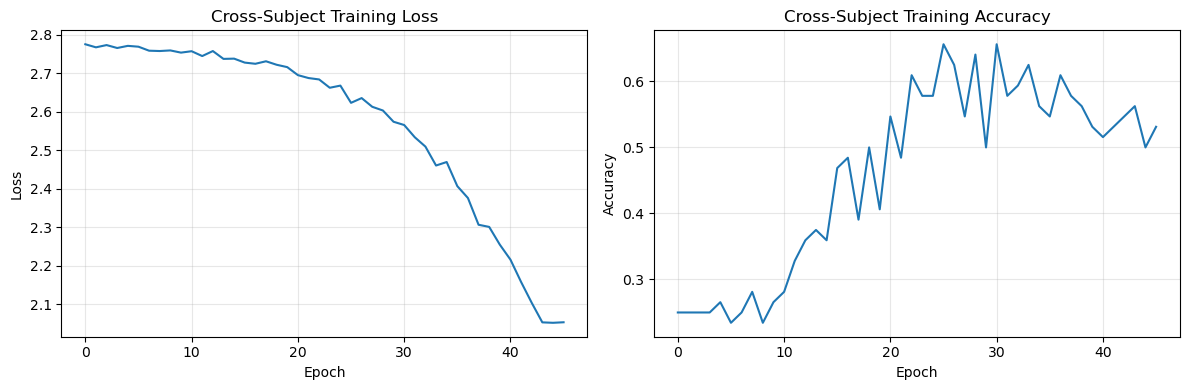


🎯 TRAINING COMPLETED
Best training accuracy: 0.6562 (65.6%)
Model saved as 'best_cnn_lstm_model.pth'

  CROSS-SUBJECT MODEL EVALUATION
Loading CNN+LSTM model from best_cnn_lstm_model.pth
CNNLSTMNet created with 2,219,476 parameters
  - Spatial features after CNN: 960
  - Temporal sequence length: 69
  - LSTM hidden size: 64 (bidirectional: 128)

--- Evaluating on test1 ---
Found 16 files in test1
test1 - Accuracy: 0.4375 (43.8%), Loss: 0.6819, Samples: 16

--- Evaluating on test2 ---
Found 16 files in test2
test2 - Accuracy: 0.4375 (43.8%), Loss: 0.6652, Samples: 16

--- Evaluating on test3 ---
Found 16 files in test3
test3 - Accuracy: 0.5625 (56.2%), Loss: 0.6641, Samples: 16

--- OVERALL RESULTS ---
Individual test accuracies: ['0.438', '0.438', '0.562']
Mean accuracy: 0.4792 ± 0.0589
Weighted average accuracy: 0.4792
Total test samples: 48


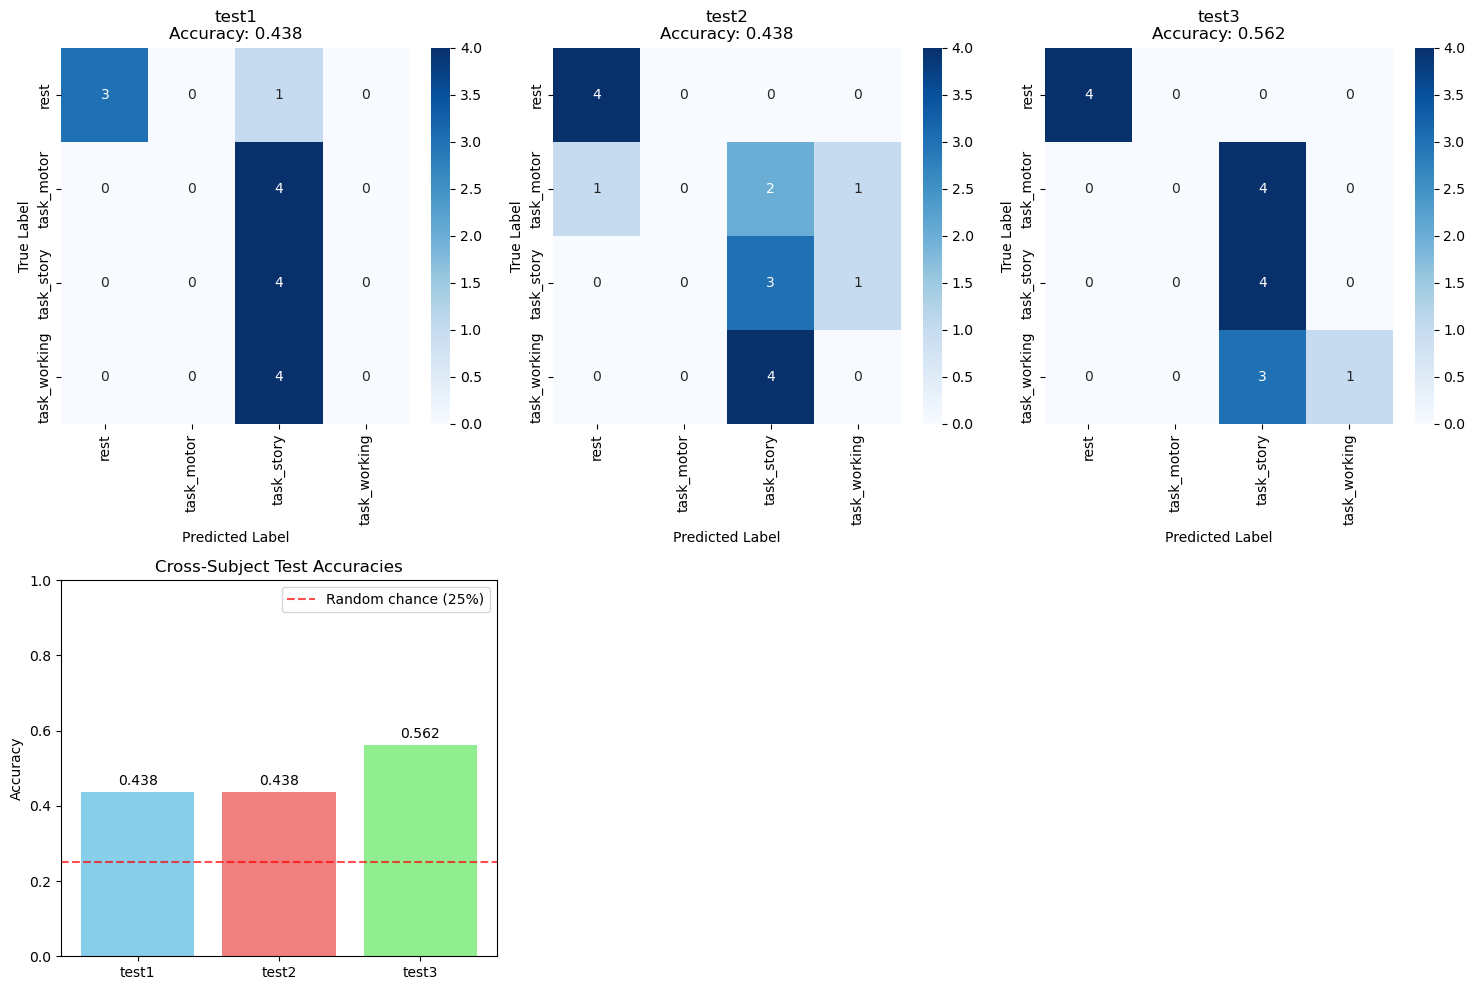


--- DETAILED CLASSIFICATION REPORTS ---

TEST1:
              precision    recall  f1-score   support

        rest      1.000     0.750     0.857         4
  task_motor      0.000     0.000     0.000         4
  task_story      0.308     1.000     0.471         4
task_working      0.000     0.000     0.000         4

    accuracy                          0.438        16
   macro avg      0.327     0.438     0.332        16
weighted avg      0.327     0.438     0.332        16


TEST2:
              precision    recall  f1-score   support

        rest      0.800     1.000     0.889         4
  task_motor      0.000     0.000     0.000         4
  task_story      0.333     0.750     0.462         4
task_working      0.000     0.000     0.000         4

    accuracy                          0.438        16
   macro avg      0.283     0.438     0.338        16
weighted avg      0.283     0.438     0.338        16


TEST3:
              precision    recall  f1-score   support

        re

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt

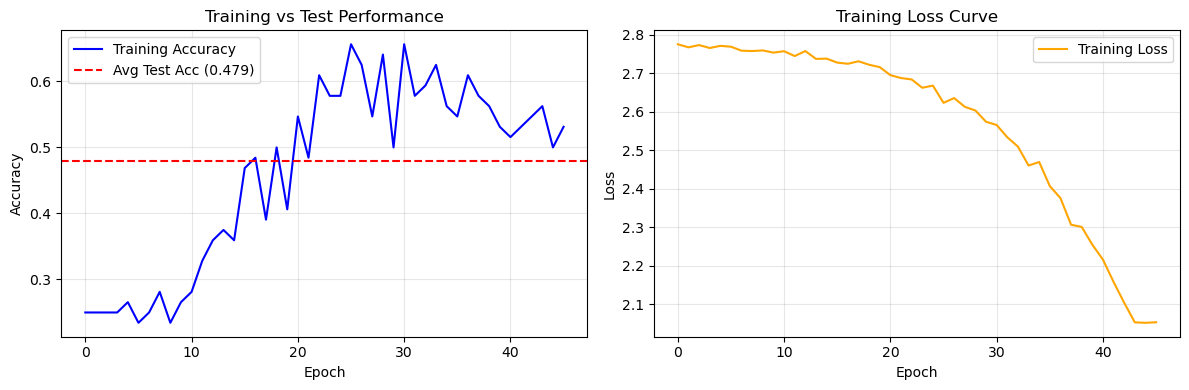


🎯 CNN+LSTM cross-subject experiment completed!
Check the plots and analysis above to see if LSTM improved generalization.


In [3]:
# Get filepath using existing utilities
filepath = get_filepath()
print(f"Base filepath: {filepath}")

# Option 1: Train and evaluate CNN+LSTM model
print("\n🧠 Training CNN+LSTM Model...")
model, losses, accs, test_results = run_complete_cross_subject_experiment(
    filepath=filepath,
    epochs=50,                
    file_batch_size=8,        
    dataloader_batch_size=2,  
    downsample_factor=16,     
    lr=0.0005,                # Lower LR for LSTM stability
    weight_decay=1e-3,        
    use_cnn_lstm=True         # Use the new CNN+LSTM model
)

# Option 2: Just evaluate existing CNN+LSTM model (uncomment if you have a trained model)
# test_results = evaluate_cross_subject_model(filepath, model_path='best_cnn_lstm_model.pth', use_cnn_lstm=True)

# Option 3: Compare with CNN-only model (uncomment to train both)
# print("\n🔄 Training CNN-only Model for comparison...")
# model_cnn, losses_cnn, accs_cnn, test_results_cnn = run_complete_cross_subject_experiment(
#     filepath=filepath, use_cnn_lstm=False, epochs=50, lr=0.001
# )

print("\n🎯 CNN+LSTM cross-subject experiment completed!")
print("Check the plots and analysis above to see if LSTM improved generalization.")


  CROSS-SUBJECT MODEL EVALUATION
Loading CNN+LSTM model from best_cnn_lstm_model.pth
CNNLSTMNet created with 2,219,476 parameters
  - Spatial features after CNN: 960
  - Temporal sequence length: 69
  - LSTM hidden size: 64 (bidirectional: 128)

--- Evaluating on test1 ---
Found 16 files in test1
test1 - Accuracy: 0.4375 (43.8%), Loss: 0.6819, Samples: 16

--- Evaluating on test2 ---
Found 16 files in test2
test2 - Accuracy: 0.4375 (43.8%), Loss: 0.6652, Samples: 16

--- Evaluating on test3 ---
Found 16 files in test3
test3 - Accuracy: 0.5625 (56.2%), Loss: 0.6641, Samples: 16

--- OVERALL RESULTS ---
Individual test accuracies: ['0.438', '0.438', '0.562']
Mean accuracy: 0.4792 ± 0.0589
Weighted average accuracy: 0.4792
Total test samples: 48


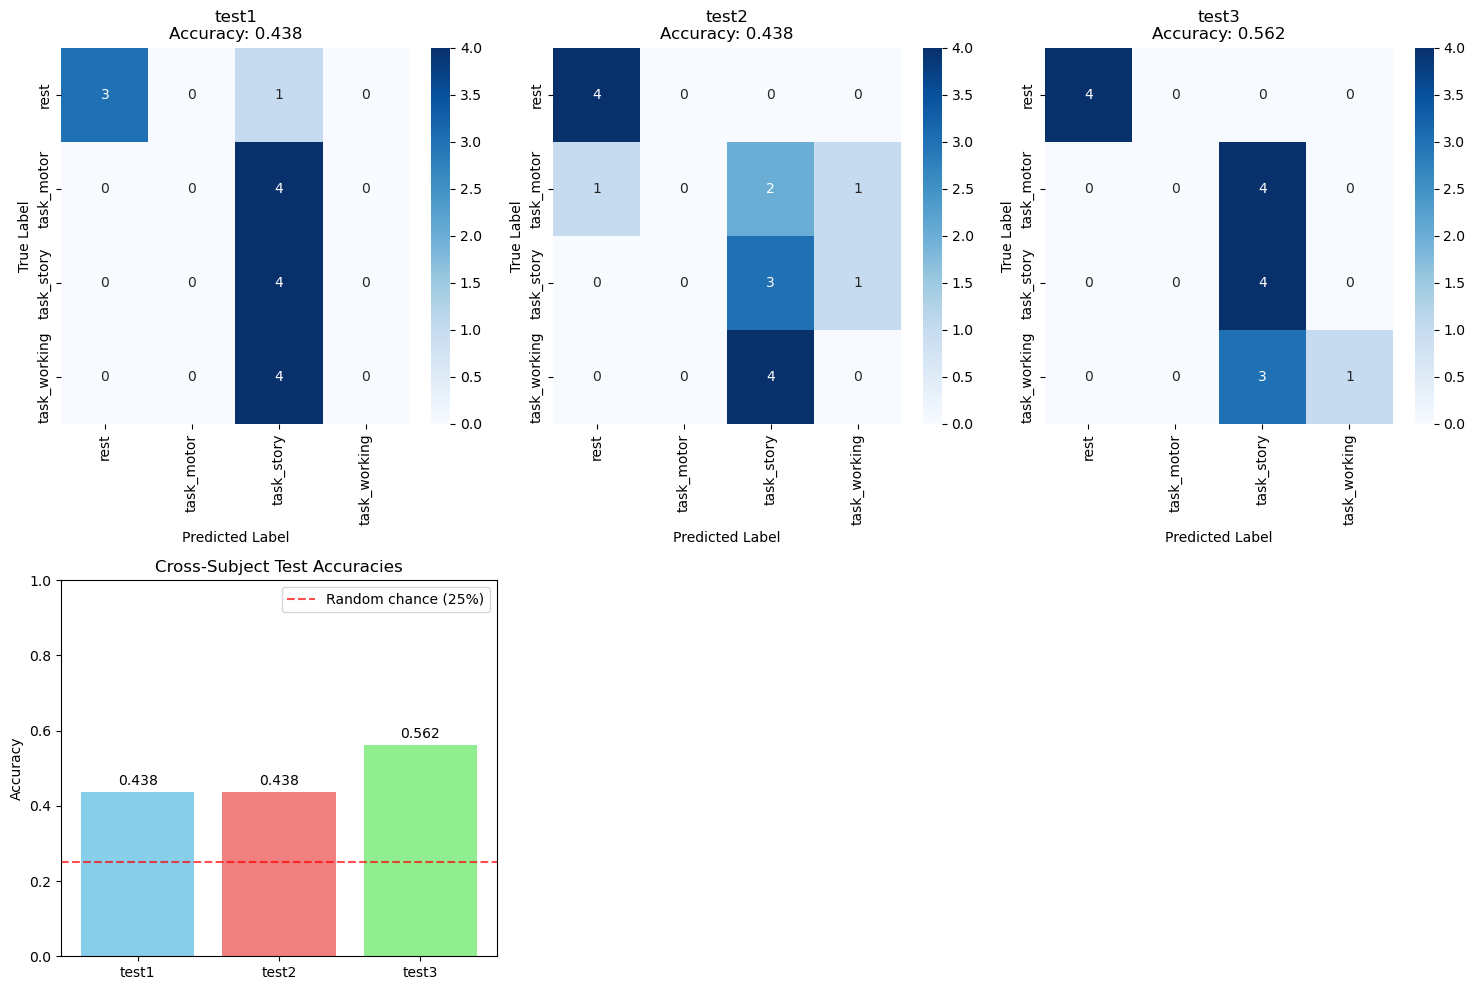


--- DETAILED CLASSIFICATION REPORTS ---

TEST1:
              precision    recall  f1-score   support

        rest      1.000     0.750     0.857         4
  task_motor      0.000     0.000     0.000         4
  task_story      0.308     1.000     0.471         4
task_working      0.000     0.000     0.000         4

    accuracy                          0.438        16
   macro avg      0.327     0.438     0.332        16
weighted avg      0.327     0.438     0.332        16


TEST2:
              precision    recall  f1-score   support

        rest      0.800     1.000     0.889         4
  task_motor      0.000     0.000     0.000         4
  task_story      0.333     0.750     0.462         4
task_working      0.000     0.000     0.000         4

    accuracy                          0.438        16
   macro avg      0.283     0.438     0.338        16
weighted avg      0.283     0.438     0.338        16


TEST3:
              precision    recall  f1-score   support

        re

/opt/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/envs/torch/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt

In [4]:
test_results = evaluate_cross_subject_model(filepath)
